<a href="https://colab.research.google.com/github/codedyasai/Python_MachineLearning/blob/main/23_Support_Vector_Machine(SVM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting

In [ ]:
# 파이썬 3.5 이상 버전 필수

import sys
assert sys.version_info >= (3, 5)

SVM
서포트 벡터(support vector) : 결정 경계선과 가장 가까이 맞닿은 데이터 포인트를 의미한다.
- 마진(margin) : 서포트 벡터와 결정 경계 사이의 거리를 말하는 것으로 SVM의 목표는 바로 이 마진을 최대로 하는 결정 경계를 찾는 것이다.
- 마진이 클수록 우리가 현재 알지 못하는 새로운 데이터에 대해 안정적으로 분류할 가능성이 높기 때문
- 비용(cost) : 성능이 좋은 머신러닝 모델이란 학습시 에러가 적은 모델이 아니라 테스트 및 운용시 에러가 적은 모델이다. 즉, 약간의 오류를 허용하기 위해 비용(C)이라는 변수를 사용한다.
- 비용이 낮을수록, 마진을 최대한 높이고, 학습 에러율을 증가시키는 방향으로 결정 경계선을 만든다.
- 비용이 높을수록, 마진은 낮아지고, 학습에러율은 감소하는 방향으로 결정 경계선을 만든다
- 비용이 너무 낮으면, 과소적합의 위험이 있고, 너무 높으면 과대적합의 위험이 있으므로 직절한 비용값을 찾는 과정이 중요하다
- 결정 경계(decision boundary : 주어진 데이터를 통해 잘 분류해내는 선
- 데이터의 벡터 공간을 N 차원이라고 할 경우, 김정 경계는 N-1차원이다.
- 만약 데이터가 3차원이라면 결정경계는 선이 아니라 면으로 나타난다. 이러한 이유로 결정 경계는 때로 초평면(hyperplane)이라고 부르기도 한다.
- 커널 트릭(kernal trick): 2차원 공간에서는 두 개의 데이터 집합을 가로지르는 선을 찾는 것이고, 3차원 공간에서는 두 개의 데이터 집합을 가로지르는 초평면을 찾는 것이 SVM의 핵심이다.
- 저차원의 데이터를 고차원의 데이터로 옮겨주는 함수는 매핑함수라고 부른다.
- 고차원으로 데이터를 옮겨서 결정 경계를 찾는 법이 커널 트릭이다.
- 선형 SVM: 커널을 사용하지 않고 데이터를 분류하는 것으로 비용(C)을 조절해서 마진의 크기를 조절
- 커널 트릭: 주어진 데이터가 선형 분리로 불가능할 경우 고차원으로 데이터를 옮기는 효과를 통해 결정 경계를 찾는 것으로 비용과 gamma를 조절해서 마진을 조절할 수 있다.
- RBF 커널: 가우시안 RBF 커널을 사용하는 것으로 가우시안 함수의 표준편차를 조정함으로써 결정 경계의 곡률을 조정하는데 이 표준편차 조정 변수를 감마라고 부른다.
- 감마가 커지면 데이터포인트별로 허용하는 표준편차가 작아져서 결정경계가 작아지면서 구부러지는 모양을 나타내다.

# 문제 정의
- 농구 선수의 경기 기록을 바탕으로 해당 선수들의 포지션을 예측해보자
- 최적의 SVM 파라미터 찾기

In [ ]:
from IPython.display import display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 음수표현 라이브러리
plt.rcParams['axes.unicode_minus'] = False

# 경고무시
import warnings
warnings.filterwarnings("ignore")

# 매직명령어 : 시각화 결과가 노트북에 포함되도록
%matplotlib inline

# 데이터 로딩

In [ ]:
df = pd.read_csv('basketball_stat.csv')

In [ ]:
x = df[['3P', 'BLK']]
y = df['Pos']
print(x.shape, y.shape)

(100, 2) (100,)


# 모델 구현

## 훈련세트와 테스트 세트 분리

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size= 0.2)

print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(80, 2) (20, 2)
(80,) (20,)


## SVM 최적의 파라미터 찾기

1. C(cost): 비용, 결정 경계선의 마진을 결정하는 파라미터
  - 클수록 하드마진, 작을수록 소프트마진
2. gamma: 커널의 데이터 포인트의 표준편차를 결정하는 파라미터
  - 'scale': 결정 경계를 얼마나 유연하게 그릴건지를 결정
  - 클수록 과대적합의 위험이 있다.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC

In [ ]:
# C(0.1)
# kernel: rbf(훈련 세트가 너무 크지 않을 때, 가우시안 커널)
# kernel은 데이터셋의 형태에 따라서 다르게 지정한다.
# 선형 데이터셋일 경우 'linear', 비선형 'poly(다항식)', 'rbg(가우시안)'

def svc_param_selection(x,y, nfolds):
    svc_params = [{'kernel': ['rbf'],
                   'gamma': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1],
                   'C': [0.01, 0.1, 1, 10, 100, 1000]}]

    clf = GridSearchCV(SVC(), svc_params, cv= nfolds)
    clf.fit(x_train, y_train)
    print(clf.best_params_)

    return clf

In [ ]:
clf = svc_param_selection(x_train, y_train, 10)

{'C': 1, 'gamma': 1, 'kernel': 'rbf'}


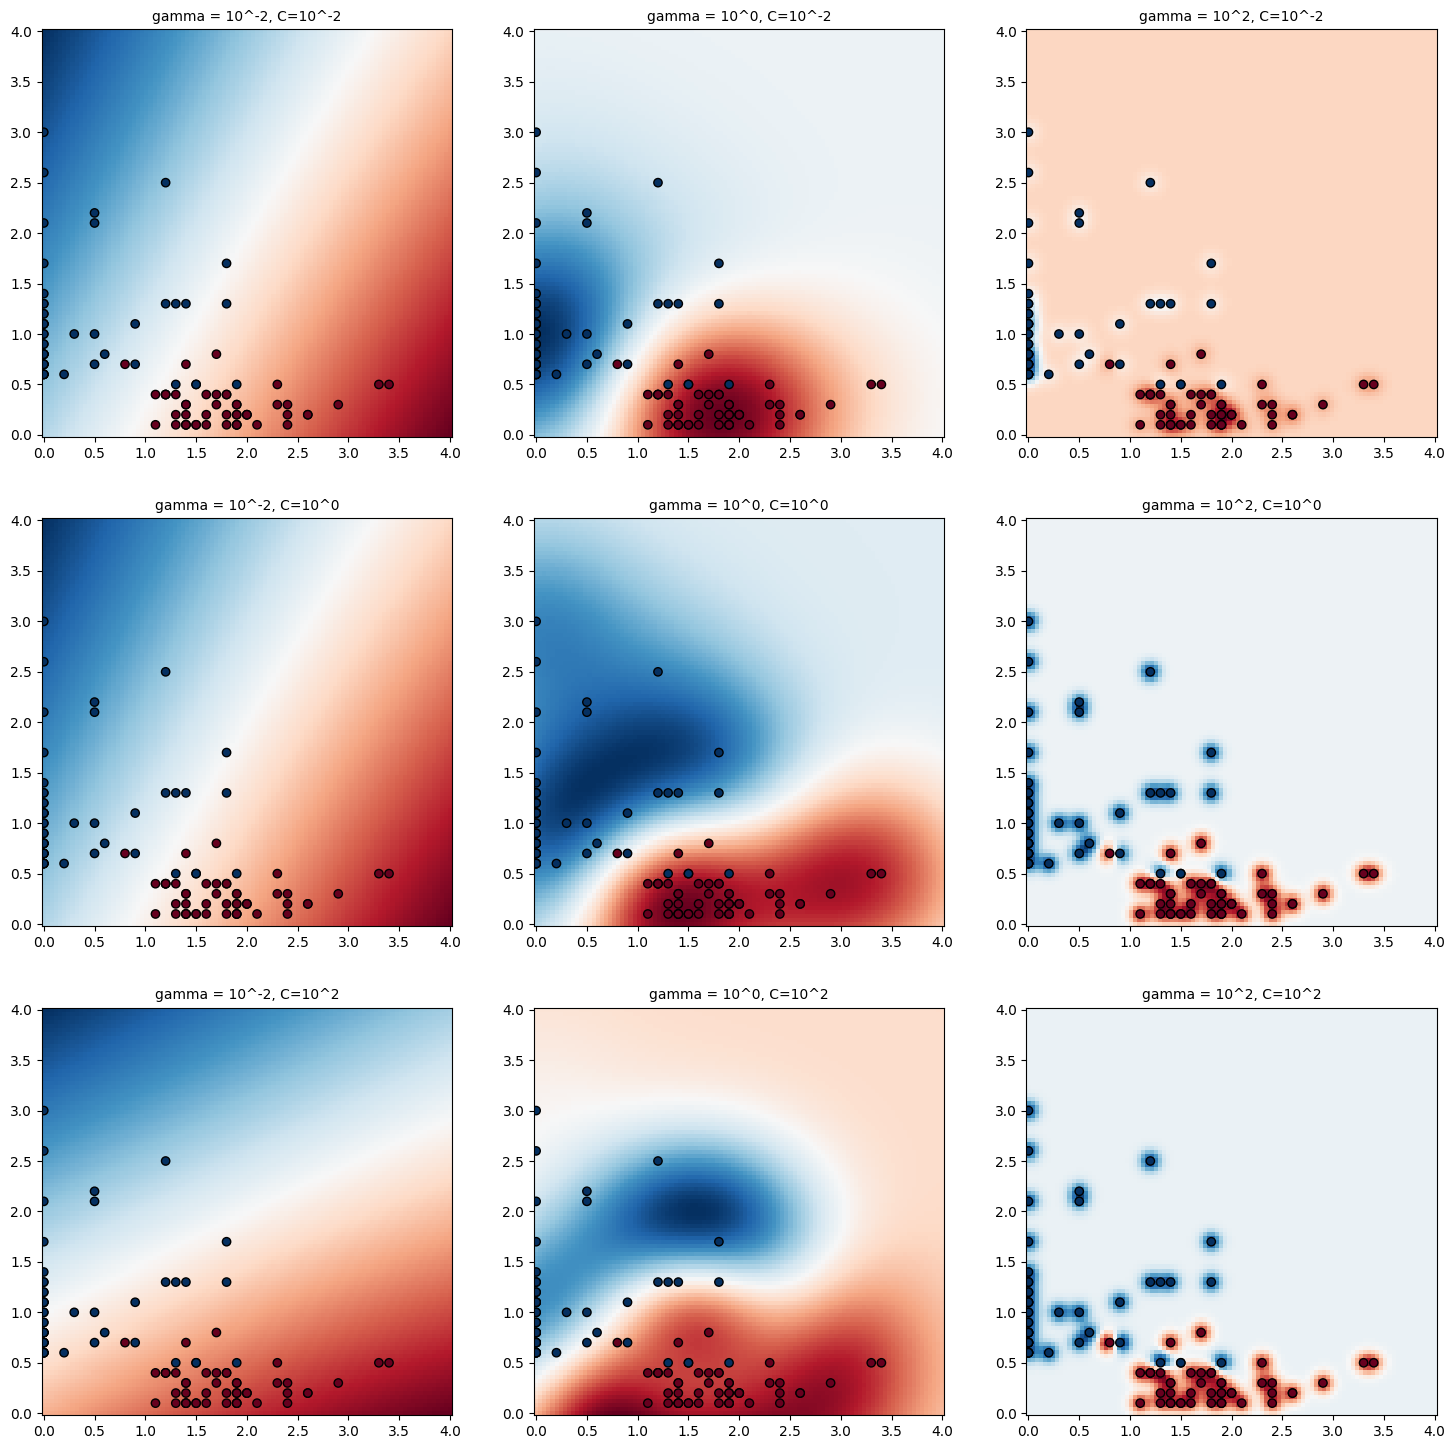

In [ ]:
# 3 by 3 시각화
c_list = []
c_list.append(clf.best_params_['C'] * 0.01)
c_list.append(clf.best_params_['C'])
c_list.append(clf.best_params_['C'] * 100)

gamma_list = []
gamma_list.append(clf.best_params_['gamma'] * 0.01)
gamma_list.append(clf.best_params_['gamma'])
gamma_list.append(clf.best_params_['gamma'] * 100)

x = df[['3P','BLK']]
y = df['Pos'].tolist()

# 포지션에 해당하는 문자열(SG, C)벡터화
position = []
for p in y:
    if p =='C':
        position.append(0)
    else:
        position.append(1)

# 각각의 파라미터에 해당하는 모델을 생성하여 해당하는
classifiers=[]
for c in c_list:
    for gamma in gamma_list:
        clf = SVC(C=c, gamma=gamma)
        clf.fit(x, y)
        classifiers.append((c, gamma, clf))

# 시각화를 위한 도화지 크기 지정
plt.figure(figsize=(18,18))
# np.meshgrid : 1차원 좌표배열 N차원 직사각형 격자를 만드는 함수
xx, yy = np.meshgrid(np.linspace(0,4,100), np.linspace(0,4,100))

# deccision_function(), predict)proba()
for (k, (c, gamma, clf)) in enumerate(classifiers):
    Z = clf.decision_function(np.c_[xx.ravel(),yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.subplot(3, 3, k+1)
    plt.title('gamma = 10^%d, C=10^%d' % (np.log10(gamma), np.log10(c)),size='medium')

    plt.pcolormesh(xx, yy, -Z, cmap = plt.cm.RdBu)
    plt.scatter(x['3P'],x['BLK'],c=position, cmap=plt.cm.RdBu_r, edgecolors='k')

In [ ]:
pred = clf.predict(x_test)
print(classification_report(y_test, pred))
print('Accuracy: ', accuracy_score(y_test, pred))

              precision    recall  f1-score   support

           C       1.00      0.92      0.96        12
          SG       0.89      1.00      0.94         8

    accuracy                           0.95        20
   macro avg       0.94      0.96      0.95        20
weighted avg       0.96      0.95      0.95        20

Accuracy:  0.95


# 보고서

In [ ]:
comparison= pd.DataFrame({'prediction': pred, 'Actual': y_test})
comparison


,prediction,Actual
13,SG,SG
10,C,C
28,SG,SG
45,SG,SG
1,C,C
54,SG,C
83,C,C
77,C,C
41,SG,SG
7,SG,SG


# 확인학습

- setosa와 versicolor만 선택하여 해당 데이터셋을 이용한 SVM 선형 분류

## 데이터 로딩

In [ ]:
from sklearn.datasets import load_iris

iris = load_iris()
dir(iris) # iris.keys()

['DESCR',
 'data',
 'data_module',
 'feature_names',
 'filename',
 'frame',
 'target',
 'target_names']

In [ ]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [ ]:
x = iris['data']
y = iris['target']

In [ ]:
condition = (y==0)|(y==1)
x = x[condition]
y = y[condition]

x.shape, y.shape

((100, 4), (100,))

In [ ]:
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size= 0.2)

print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(80, 4) (20, 4)
(80,) (20,)


In [ ]:
def svc_param_selection(x,y, nfolds):
    svc_params = [{'kernel': ['rbf'],
                   'gamma': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1],
                   'C': [0.01, 0.1, 1, 10, 100, 1000]}]

    clf = GridSearchCV(SVC(), svc_params, cv= nfolds)
    clf.fit(x_train, y_train)
    print(clf.best_params_)

    return clf

In [ ]:
clf = svc_param_selection(x_train, y_train, 10)

{'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}


In [ ]:
pred = clf.predict(x_test)
print(classification_report(y_test, pred))
print('Accuracy: ', accuracy_score(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00         8

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20

Accuracy:  1.0


In [ ]:
comparison= pd.DataFrame({'prediction': pred, 'Actual': y_test})
comparison


,prediction,Actual
0,0,0
1,1,1
2,1,1
3,0,0
4,1,1
5,1,1
6,1,1
7,1,1
8,1,1
9,0,0
